### Transformation Testing

In [ ]:
import cc3d
import numpy as np
from scipy.ndimage import distance_transform_edt


#Create 10x10 numpy array with random 0s and 255s
np.random.seed(0)
random_array = np.random.choice([0, 255], size=(10, 10), p=[0.7, 0.3]).astype(np.uint8)
filtered_array = cc3d.dust(random_array, threshold=2, connectivity=8, in_place=False)
entity_array, num_entities = cc3d.connected_components(filtered_array, connectivity=8, return_N=True)
print('Original Array:')
print(random_array)
print()
print('Filtered Array:')
print(filtered_array)
print('Entity Array')
print(entity_array)


#Create a point array
np.random.seed(31)
point_array = np.random.choice([0, 1], size=(10, 10), p=[0.95, 0.05]).astype(np.uint8)
print('Point Array:')
print(point_array)


#Convert points to boolean array
points_mask = (point_array > 0)


#Distance transform to distance array using inverse (bitwise NOT) of points mask
dist_to_points = distance_transform_edt(~points_mask)


#Create boolean mask of voxels within 15 units of any point
near_points = dist_to_points <= 2


#Keep only entities that overlap with near_points
#Step 1: Get intersection of near_points and entity voxels (using boolean AND) and keep only those labels
keep_labels = np.unique(entity_array[near_points & (entity_array > 0)])
#Step 2: Filter entity array to keep only labels found in Step 1
filtered_entity_array = np.where(np.isin(entity_array, keep_labels), entity_array, 0)
print(filtered_entity_array)


In [12]:
import cc3d
import numpy as np
from scipy.ndimage import distance_transform_edt


#Create 10x10 numpy array with random 0s and 255s
np.random.seed(2)
random_array = np.random.choice([0, 255], size=(10, 10), p=[0.7, 0.3]).astype(np.uint8)
filtered_array = cc3d.dust(random_array, threshold=2, connectivity=8, in_place=False)
entity_array, num_entities = cc3d.connected_components(filtered_array, connectivity=8, return_N=True)
print('Original Array:')
print(random_array)
print()
print('Filtered Array:')
print(filtered_array)
print('Entity Array')
print(entity_array)

#Create a point array
np.random.seed(31)
point_array = np.random.choice([0, 1], size=(10, 10), p=[0.9, 0.1]).astype(np.uint8)
print('Point Array:')
print(point_array)

#Convert to boolean masks (140GB RAM)
points_bool = (point_array > 0)
preds_bool = (filtered_array > 0)

#Compute distance transform from predicted gap junctions (280GB + 210GB RAM)
distance, nearest_indices = distance_transform_edt(~preds_bool, return_indices=True)
print('Distance Array')
print(np.round(distance, 2))
print('Nearest Indices Array')
print(nearest_indices)

#Transform points from 3D array to a list of points
points_list = np.argwhere(points_bool) #shape: (N_points, 3)
print('Points List')
print(points_list)

#Refine points_list to only include points with distance < 2 voxels to nearest gap junction entity
max_distance = 2
points_list_filtered = points_list[distance[points_list[:,0], points_list[:,1]] < max_distance]
num_points = len(points_list)
num_moved_points = len(points_list_filtered)
print('Distance[Points_List]:')
print(distance[points_list[:,0], points_list[:,1]])
print('Less than max distance:')
print(distance[points_list[:,0], points_list[:,1]] < max_distance)
print('Points List Filtered')
print(points_list_filtered)

#For each point find its nearest predicted gap junction
#nearest_indices has shape (3, D, H, W) with [z, y, x] indices at each voxel
nearest_gap_junctions_list = nearest_indices[:, points_list_filtered[:,0], points_list_filtered[:,1]].T
#nearest_gap_junctions now has shape (N_points, 3)
print('Nearest Gap Junctions List:')
print(nearest_gap_junctions_list)

#Create an array of moved points (70GB RAM)
moved_points = np.zeros_like(point_array, dtype=np.uint8)
moved_points[nearest_gap_junctions_list[:,0], nearest_gap_junctions_list[:,1]] = 255
print('Moved Points Array:')
print(moved_points)

#Report statistics
distances_moved = distance[points_list_filtered[:,0], points_list_filtered[:,1]]
#distances_moved has shape (N, 1)
print(f"Moved {len(points_list_filtered)} points to nearest blobs")
print(f"Mean distance moved: {distances_moved.mean():.2f} voxels")
print(f"Max distance moved: {distances_moved.max():.2f} voxels")
print(f'Number of original points: {num_points}')
print(f'Number of moved points: {num_moved_points}')

Original Array:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0 255]
 [255   0 255   0   0   0   0 255   0 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [255   0 255   0   0   0   0   0 255   0]
 [  0   0   0   0 255 255   0   0 255   0]
 [  0   0   0   0   0   0   0   0 255   0]
 [  0   0 255   0   0   0   0   0   0 255]]

Filtered Array:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0 255]
 [  0   0 255   0   0   0   0 255   0 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [  0   0 255   0   0   0   0   0 255   0]
 [  0   0   0   0 255 255   0   0 255   0]
 [  0   0   0   0   0   0   0   0 255   0]
 [  0   0   0   0   0   0   0   0   0 255]]
Entity Array
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 2]


In [ ]:
#Testing NR dilation and entity calculations between predictions and points
import numpy as np
from scipy.ndimage import binary_dilation
import cc3d

a = np.zeros((25, 25), dtype=np.uint8)
a[12:14, 12:14] = 255
a_dilated = binary_dilation(a, iterations=3).astype(np.uint8)
points = np.random.choice([0, 255], size=(25, 25), p=[0.95, 0.05]).astype(np.uint8)
preds = np.random.choice([0, 255], size=(25, 25), p=[0.7, 0.3]).astype(np.uint8)

In [33]:
#Get predictions only in nerve ring
NR_preds = preds & a_dilated
#Transform predictions to entities
NR_preds_entities, max_entities = cc3d.connected_components(NR_preds, connectivity=8, return_N=True)
#Create list of entity labels
entity_list = list(range(max_entities + 1))
#Create list of point coordinates
points_list = np.argwhere(points == 255)

#Get entity labels at point locations
entity_labels_at_points = NR_preds_entities[points_list[:, 0], points_list[:, 1]]

#TP: Entities that contain at least one point
tp_entities = set(entity_labels_at_points[entity_labels_at_points > 0])
tp = len(tp_entities)

#FP: Entities that don't contain any points
all_entities = set(range(1, max_entities + 1))
fp_entities = all_entities - tp_entities
fp = len(fp_entities)

#FN: Points that don't fall within any entity (in background)
fn = np.sum(entity_labels_at_points == 0)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP (entities with points): {tp}")
print(f"FP (entities without points): {fp}")
print(f"FN (points not in any entity): {fn}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


TP (entities with points): 1
FP (entities without points): 2
FN (points not in any entity): 40
Precision: 0.333, Recall: 0.024, F1: 0.045


In [32]:
NR_preds_entities

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
np.set_printoptions(linewidth=200, threshold=10000)
print("Dilated:")
print(a_dilated)
print("Points:")
print(points)
print("Preds:")
print(preds)
print("NR_preds:")
print(NR_preds)
print('Entity labels at points:')
print(entity_labels_at_points)


Dilated:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Prediction vs EM Comparisons

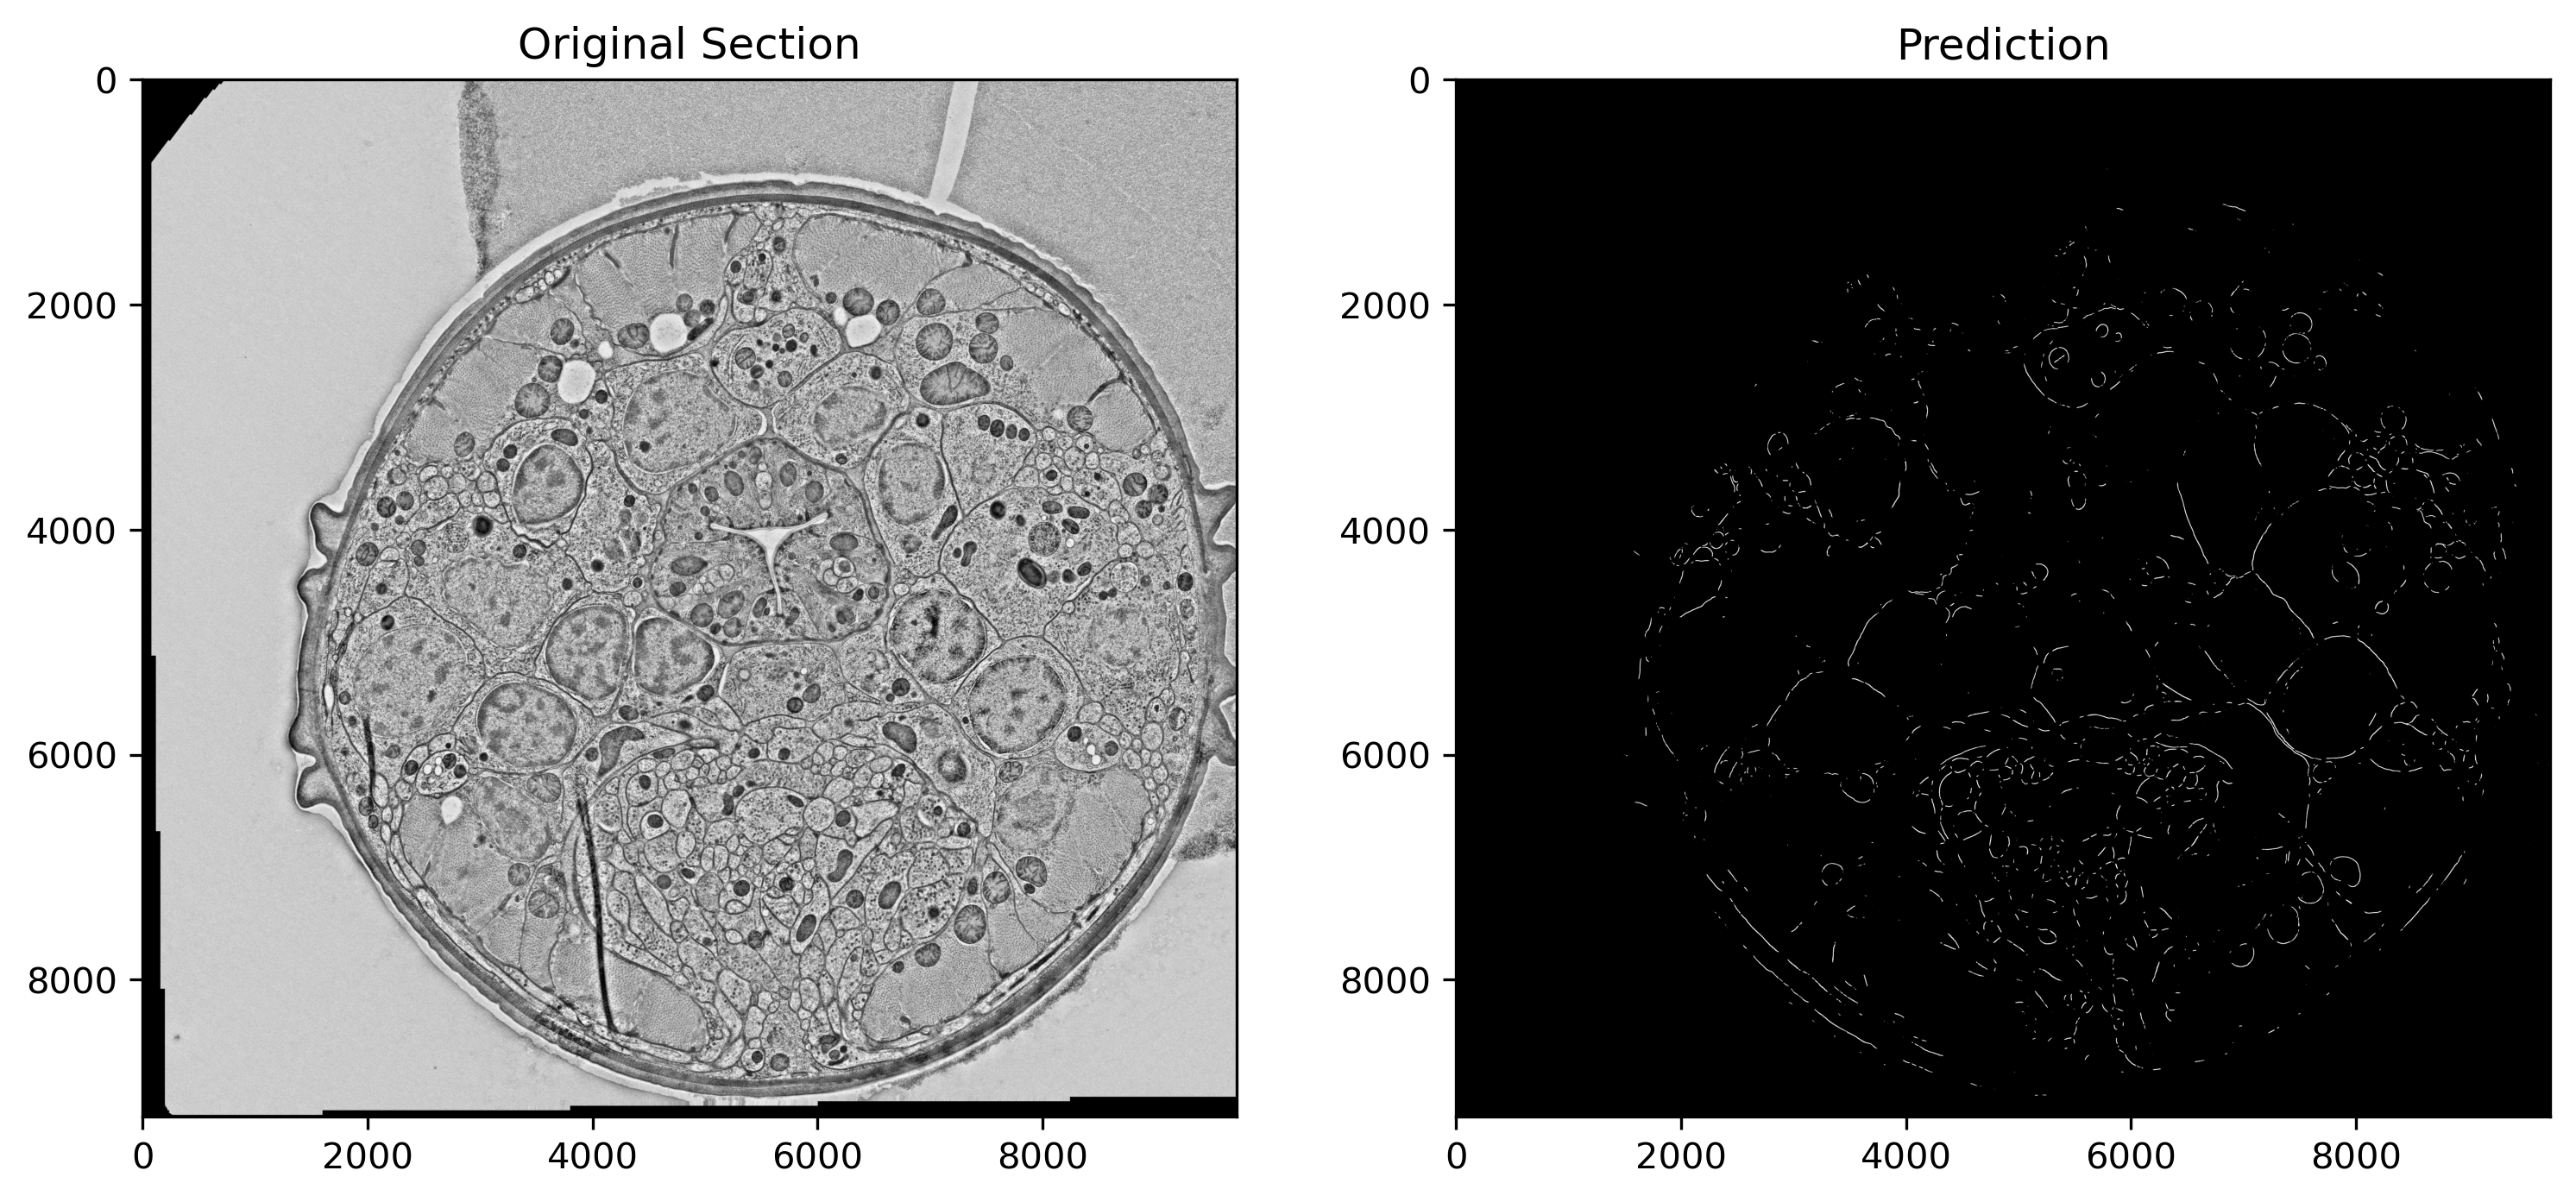

In [68]:
import matplotlib.pyplot as plt
import cv2

section_path = "/mnt/e/Tommy/SEM_dauer_1/Sections/SEM_dauer_1_export_s250.png"
prediction_path = "/mnt/e/Tommy/SEM_dauer_1/Predictions/3D/SEM_dauer_1_export_s250_pred.png"

section = cv2.imread(section_path, cv2.IMREAD_GRAYSCALE)
prediction = cv2.imread(prediction_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6), dpi=300)
plt.subplot(121)
plt.title("Original Section")
plt.imshow(section, cmap='gray')
plt.subplot(122)
plt.title("Prediction")
plt.imshow(prediction, cmap='gray')
plt.show()

In [ ]:
pred2 = cv2.cvtColor(prediction, cv2.COLOR_GRAY2BGR)
pred2[prediction == 255] = [0, 60, 255] #Blue
pred_overlay = cv2.addWeighted(cv2.cvtColor(section, cv2.COLOR_GRAY2BGR), 1, pred2, 1, 0)
plt.figure(dpi=1000)
plt.imshow(pred_overlay)
plt.title("Overlay")
plt.axis('off')
plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread("/mnt/e/Tommy/SEM_adult_larger/Neurons/SEM_adult_image_export_s500.png", cv2.IMREAD_UNCHANGED)
#plt.imshow(img, cmap='gray', vmax=50)
print(np.unique(img, return_counts=True))

(array([  0,   1,   2,   4,   7,  10,  11,  12,  13,  15,  16,  17,  23,
        25,  26,  27,  29,  30,  32,  35,  37,  39,  41,  47,  49,  50,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  64,  65,  68,
        69,  70,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  86,  87,  89,  91,  92,  93,  95,  96,  97,  98,  99, 101,
       102, 106, 107, 108, 109, 110, 114, 116, 118, 120, 122, 123, 124,
       127, 128, 129, 131, 133, 135, 139, 140, 142, 144, 146, 147, 150,
       151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166,
       167, 168, 170, 171, 174, 177, 178, 179, 182, 183, 185, 186, 187,
       189, 190, 191, 192, 196, 198, 199, 200, 202, 203, 204, 205, 206,
       208, 209, 212, 213, 214, 215, 216, 217, 230], dtype=uint16), array([214261665,    101712,      1260,     48504,      5376,      2216,
            2576,      5548,     88064,     25092,     51468,     60972,
          113104,     23148,     13892,     26372,      7228,    

### 3D Version of PredictMultipleModels() (Needs to be converted to a function and incorporated into PredictMultipleModels)

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of AlbumentationsX (2.0.13) is available! Your version is 2.0.9. Upgrade using: pip install -U albumentationsx
  check_for_updates()


Shape of augmented image: (512, 512, 1)
Shape of volume before model: torch.Size([1, 1, 9, 512, 512])
Shape of augmented image: (512, 512, 1)
Shape of volume before model: torch.Size([1, 1, 9, 512, 512])


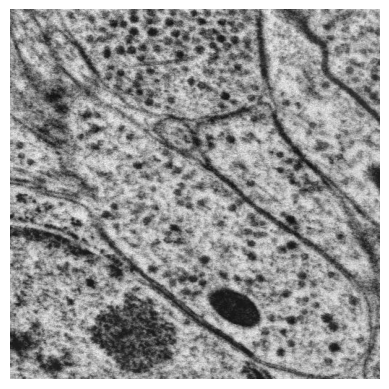

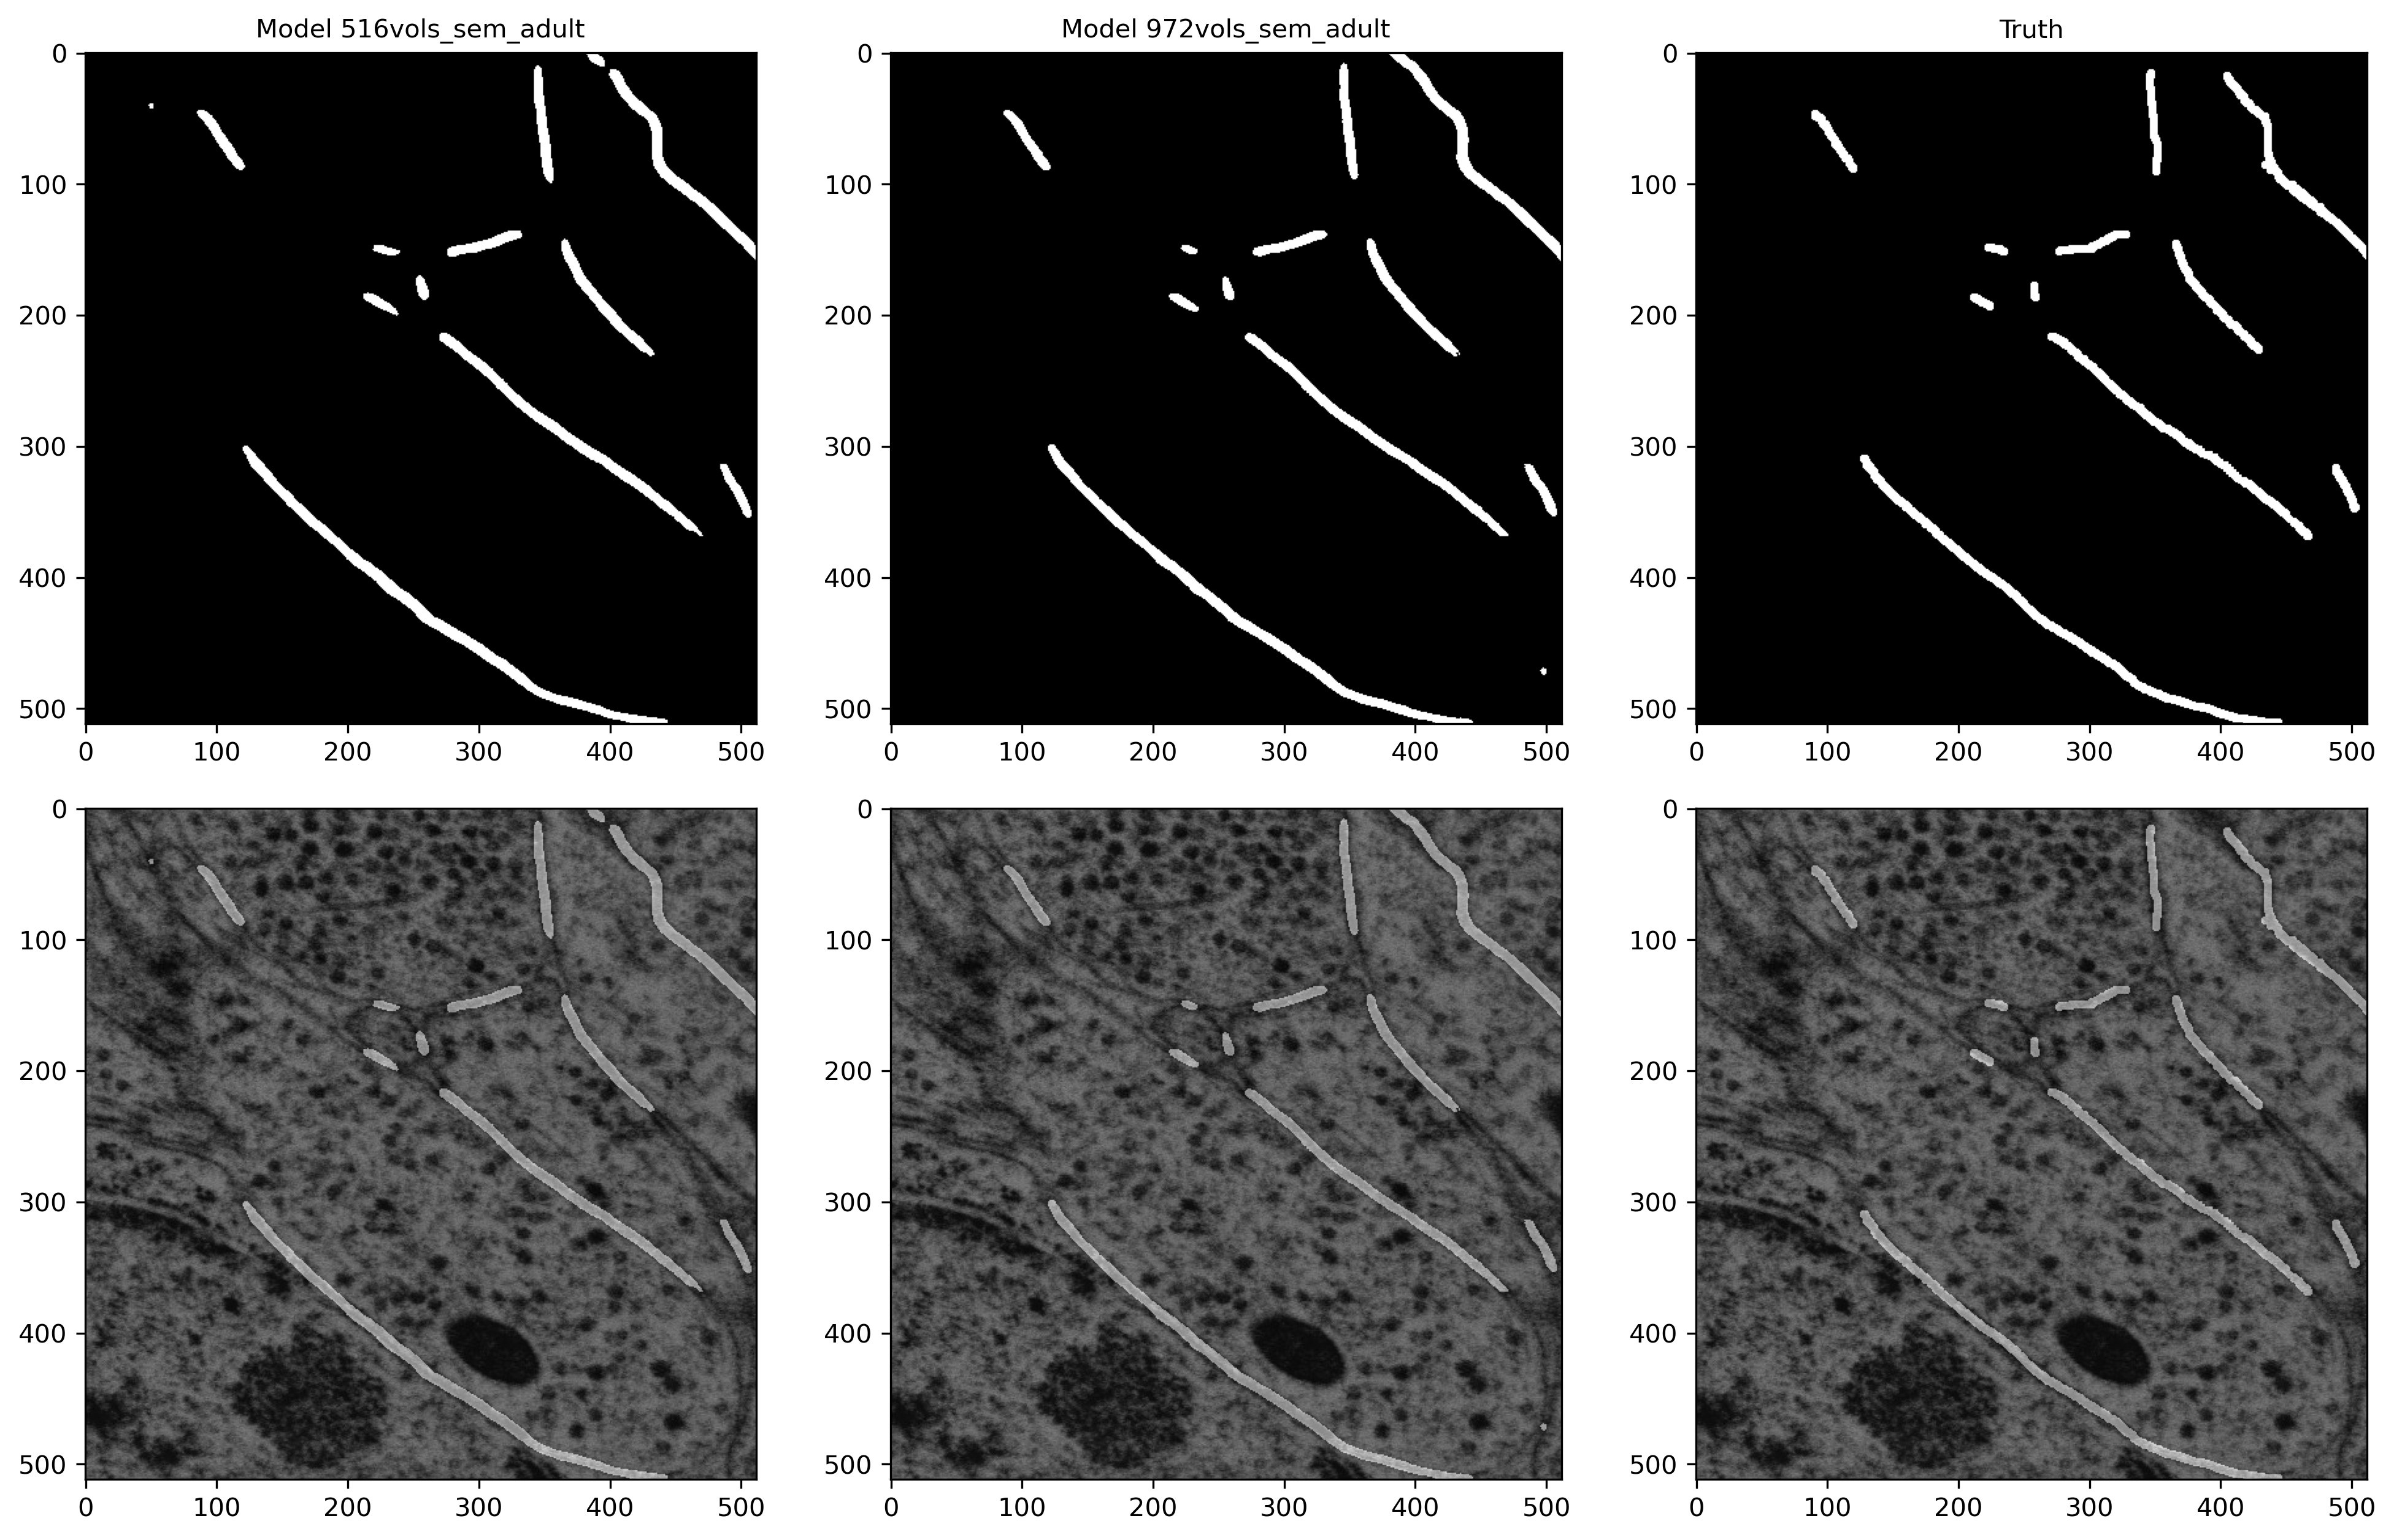

In [1]:
import matplotlib.pyplot as plt
import cv2
import os 
import numpy as np
from pathlib import Path
import sys
sys.path.append('/home/tommytang111/gap-junction-segmentation/code/src')
from utils import single_volume_inference
import random
from models import UNet
import re
import albumentations as A

#Plot two model predictions side by side with ground truth
valid_augmentation3D = A.Compose([A.Normalize(mean=0, std=1)])
data_dir = "/home/tommytang111/gap-junction-segmentation/data/972vols_sem_adult"
vol = os.listdir(Path(data_dir) / "vols")
random_vol = random.choice(vol)
random_vol_path = Path(data_dir) / "vols" / random_vol

vol1 = np.load(random_vol_path)
gts1 = cv2.imread(Path(data_dir) / "gts" / re.sub(r'.npy$', r'_label.png', str(random_vol)), cv2.IMREAD_GRAYSCALE)

model1_pred = single_volume_inference(volume=vol1,
                model_path="/home/tommytang111/gap-junction-segmentation/models/best_models/unet_3D2D_516vols_sem_adult_u4lqcs5g.pt",
                model=UNet(classes=1, three=True),
                augmentation=valid_augmentation3D
                )
                
model2_pred = single_volume_inference(volume=vol1,
                model_path="/home/tommytang111/gap-junction-segmentation/models/newest_models/unet_3D2D_972vols_sem_adult_5dggwboi.pt",
                model=UNet(classes=1, three=True),
                augmentation=valid_augmentation3D)

center_img = vol1[4]
fig1 = plt.figure(1)
plt.imshow(center_img, cmap='gray')
plt.axis('off')

#Plot
fig2 = plt.figure(2, figsize=(16, 12), dpi=300)
plt.subplot(231)
plt.imshow(model1_pred, cmap='gray')
plt.title('Model 516vols_sem_adult', fontsize=10)
plt.subplot(232)
plt.imshow(model2_pred, cmap='gray')
plt.title('Model 972vols_sem_adult', fontsize=10)
plt.subplot(233)
plt.imshow(gts1, cmap='gray')
plt.title('Truth', fontsize=10)
plt.subplot(234)
plt.imshow(center_img, cmap='gray')
plt.imshow(model1_pred, cmap='gray', alpha=0.5)
plt.subplot(235)
plt.imshow(center_img, cmap='gray')
plt.imshow(model2_pred, cmap='gray', alpha=0.5)
plt.subplot(236)
plt.imshow(center_img, cmap='gray')
plt.imshow(gts1, cmap='gray', alpha=0.5)
#plt.tight_layout
plt.subplots_adjust(wspace=0.2, hspace=-0.2)

### Neuron Mask Generation

In [1]:
#Imports
import numpy as np
from scipy.ndimage import binary_dilation, binary_fill_holes, binary_closing
from skimage.morphology import ball, remove_small_holes

In [74]:
np.set_printoptions(linewidth=200, threshold=10000)
test_array = np.ones([5, 15, 15], dtype=np.uint8)
test_array[1:3,:,:] = 0
test_array[2, 2:7, 2:7] = 1
test_array[2, 2:7, 10:15] = 1
test_array[2,4,7:10] = 1
test_array[2,2,4] = 0
test_array[2,2,12] = 0
test_array[2,4,4]=0
test_array[2,4,12]=0
print(test_array, sep="")

[[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0

In [77]:
binary_closing(test_array, structure=ball(0)).astype(np.uint8)
#binary_fill_holes(test_array).astype(np.uint8)

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        

In [57]:
np.set_printoptions(linewidth=300, threshold=10000)

# Test with different radii
for radius in [1, 2, 3, 4]:
    struct = ball(radius)
    closed = binary_closing(test_array, structure=struct)
    
    print(f"\n{'='*60}")
    print(f"Radius {radius} (diameter ~{radius*2+1}):")
    print(f"  Structuring element size: {struct.shape}")
    print(f"  Input voxels: {test_array.sum()}")
    print(f"  Output voxels: {closed.sum()}")
    print(f"  Percentage remaining: {100 * closed.sum() / test_array.sum():.1f}%")
    
    if closed.sum() > 0:
        print(f"  Middle slice:\n{closed[1].astype(int)}")
    else:
        print(f"  Result: ALL ZEROS (features completely eroded)")


Radius 1 (diameter ~3):
  Structuring element size: (3, 3, 3)
  Input voxels: 53
  Output voxels: 48
  Percentage remaining: 90.6%
  Middle slice:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 1 1 1 1 0]
 [0 0 1 1 1 1 1 0 0 0 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 0 0 0 1 1 1 1 0]
 [0 0 1 1 1 1 1 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Radius 2 (diameter ~5):
  Structuring element size: (5, 5, 5)
  Input voxels: 53
  Output voxels: 0
  Percentage remaining: 0.0%
  Result: ALL ZEROS (features completely eroded)

Radius 3 (diameter ~7):
  Structuring element size: (7, 7, 7)
  Input voxels: 53
  Output voxels: 0
  Percentage remaining: 0.0%
  Result: ALL ZEROS (features completely eroded

In [82]:
def create_neuron_cluster_mask(neuron_volume, 
                               dilation_radius=5, 
                               min_hole_size=1000):
    """
    Create encompassing mask using morphological operations.
    Best balance of speed, accuracy, and organic shape preservation.
    """
    # Binarize neuron labels
    binary_neurons = (neuron_volume > 0).astype(np.uint8)
    
    # Create structuring element
    struct_elem = ball(radius=dilation_radius)
    
    # Close gaps between neurons smaller than structuring element
    closed = binary_closing(binary_neurons, structure=struct_elem)
    
    # Remove small holes that might be intentional gaps
    filled = remove_small_holes(closed, area_threshold=min_hole_size)
    
    # Fill any holes surrounded by positive class
    final_mask = binary_fill_holes(filled)
    
    return (final_mask * 255).astype(np.uint8)

In [87]:
create_neuron_cluster_mask(test_array, 1, 1)

array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [ ]:
# Usage
mask = create_neuron_cluster_mask(
    test_array, 
    dilation_radius=5,   # Adjust based on neuron spacing
    min_hole_size=1000   # Remove holes smaller than this
)

ValueError: Empty meshes cannot be plotted. Input mesh has zero points. To allow plotting empty meshes, set `pv.global_theme.allow_empty_mesh = True`

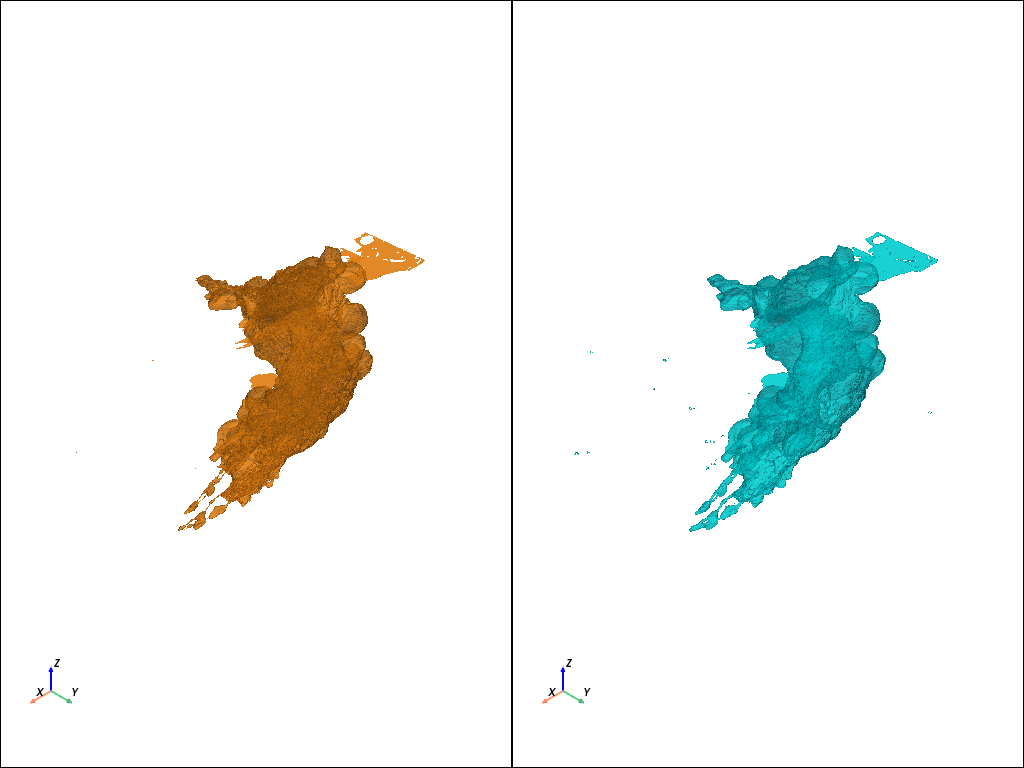

In [9]:
# Visualize result
import pyvista as pv
from skimage.measure import block_reduce
import numpy as np

neurons = np.load("/Users/tommy/Projects/gap-junction-segmentation/data/SEM_adult_neurons_unfiltered_block_downsampled8x.npy")
neuron_mask = np.load("/Users/tommy/Projects/gap-junction-segmentation/data/SEM_adult_NR_mask_downsampled8x.npy")
neurons_ = block_reduce(neurons, block_size=(2,2,2), func=np.max)
neuron_mask_ = block_reduce(neuron_mask, block_size=(2,2,2), func=np.max)
neurons_T = np.transpose(neurons_, (2, 1, 0))
neuron_mask_T = np.transpose(neuron_mask_, (2, 1, 0))

grid1 = pv.wrap(neurons_T)
grid2 = pv.wrap(neuron_mask_T)
contour1 = grid1.contour(isosurfaces=[255])
contour2 = grid2.contour(isosurfaces=[255])

pv.set_jupyter_backend("static")
p = pv.Plotter(shape=(1,2))
p.add_mesh(contour1, color="#FA9017", opacity=0.7, smooth_shading=True)
p.add_axes()
p.zoom_camera(1.2)
p.camera_position = 'iso'
p.subplot(0,1)
p.add_mesh(contour2, color="#02EBFC", opacity=0.7, smooth_shading=True)
p.add_axes()
p.zoom_camera(1.2)
p.camera_position = 'iso'

p.link_views()
p.show()

In [6]:
#Get neuron ids from csv
import pandas as pd
df = pd.read_csv("/Users/tommy/Projects/gap-junction-segmentation/neuron_ids_no_muscles.csv")
sem_adult_neuron_ids = df[df['adult']>0]['adult'].tolist()
sem_adult_neuron_ids

[133,
 169,
 80,
 184,
 70,
 112,
 151,
 42,
 84,
 51,
 116,
 148,
 76,
 187,
 4,
 66,
 10,
 170,
 127,
 45,
 25,
 111,
 131,
 123,
 211,
 179,
 14,
 150,
 78,
 140,
 27,
 193,
 60,
 113,
 53,
 172,
 182,
 6,
 109,
 104,
 114,
 145,
 108,
 26,
 216,
 213,
 91,
 30,
 214,
 212,
 205,
 68,
 110,
 37,
 217,
 215,
 203,
 156,
 97,
 102,
 128,
 71,
 135,
 134,
 87,
 15,
 98,
 154,
 190,
 130,
 41,
 34,
 202,
 121,
 164,
 198,
 176,
 67,
 171,
 103,
 20,
 5,
 13,
 19,
 197,
 105,
 39,
 136,
 96,
 161,
 200,
 201,
 16,
 115,
 118,
 94,
 124,
 9,
 204,
 117,
 32,
 90,
 206,
 166,
 189,
 99,
 55,
 100,
 81,
 79,
 7,
 29,
 40,
 199,
 22,
 92,
 49,
 1,
 59,
 74,
 142,
 160,
 2,
 147,
 75,
 73,
 159,
 191,
 83,
 139,
 120,
 65,
 183,
 122,
 23,
 43,
 89,
 17,
 11,
 50,
 77,
 86,
 158,
 44,
 93,
 129,
 174,
 46,
 54,
 106,
 155,
 192,
 35,
 196,
 153,
 18,
 58,
 168,
 62,
 186,
 95,
 173,
 163,
 24,
 167,
 38,
 57,
 132,
 107,
 33,
 72,
 181,
 101,
 64,
 208,
 119,
 12,
 185,
 157,
 162]

### Membrane Extraction

In [ ]:
import numpy as np
neurons = np.load("/home/tommy111/gap-junction-segmentation/temp/SEM_adult_neurons_only_block_downsampled4x.npy")
neuron_labels = np.load("/home/tommy111/gap-junction-segmentation/temp/SEM_adult_neurons_only_with_labels_block_downsampled4x.npy")

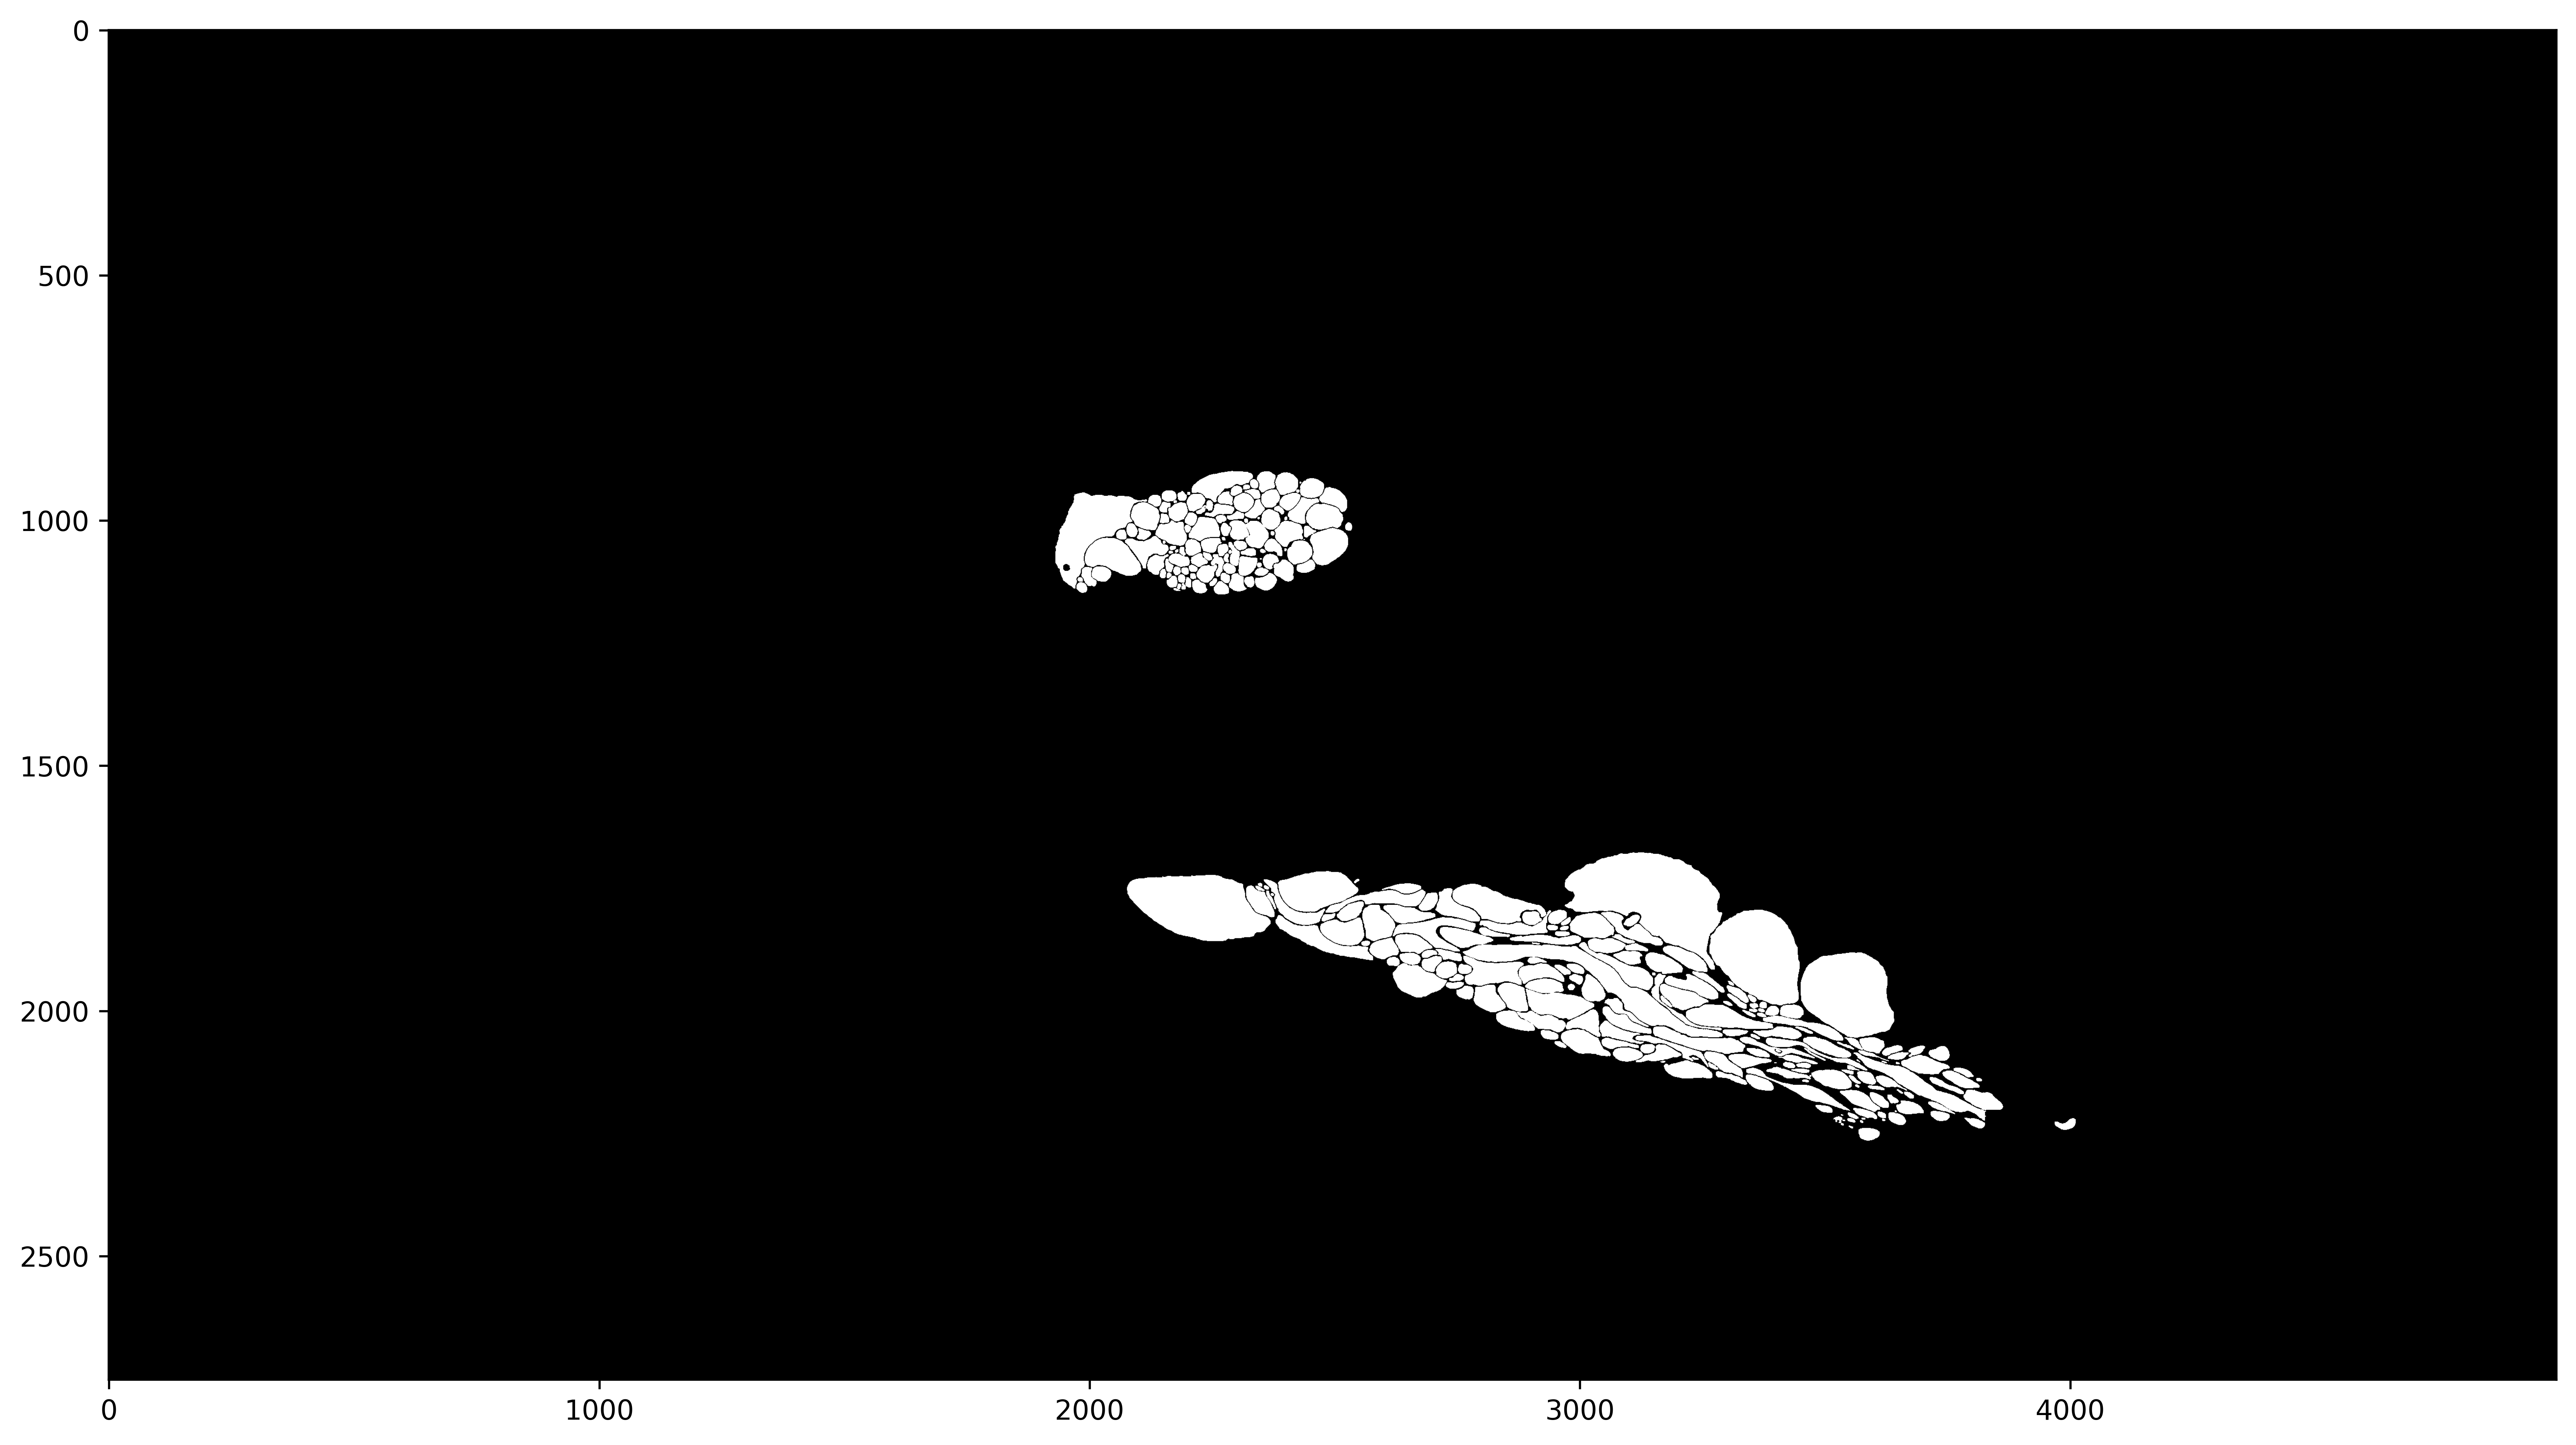

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10), dpi=600)
plt.imshow(neurons[300,:,:], cmap='gray')

In [4]:
#extract_membrane
def extract_membranes(neurons:np.ndarray | str) -> np.ndarray:
    from scipy.ndimage import grey_erosion
    
    membrane = np.zeros_like(neurons, dtype=np.uint8)
    for z in range(neurons.shape[0]):
        eroded = grey_erosion(neurons[z], size=3)
        membrane[z] = (neurons[z] != eroded).astype(np.uint8) * 255
        
    return membrane

membrane = extract_membranes(neurons)

Text(0.5, 1.0, 'Test')

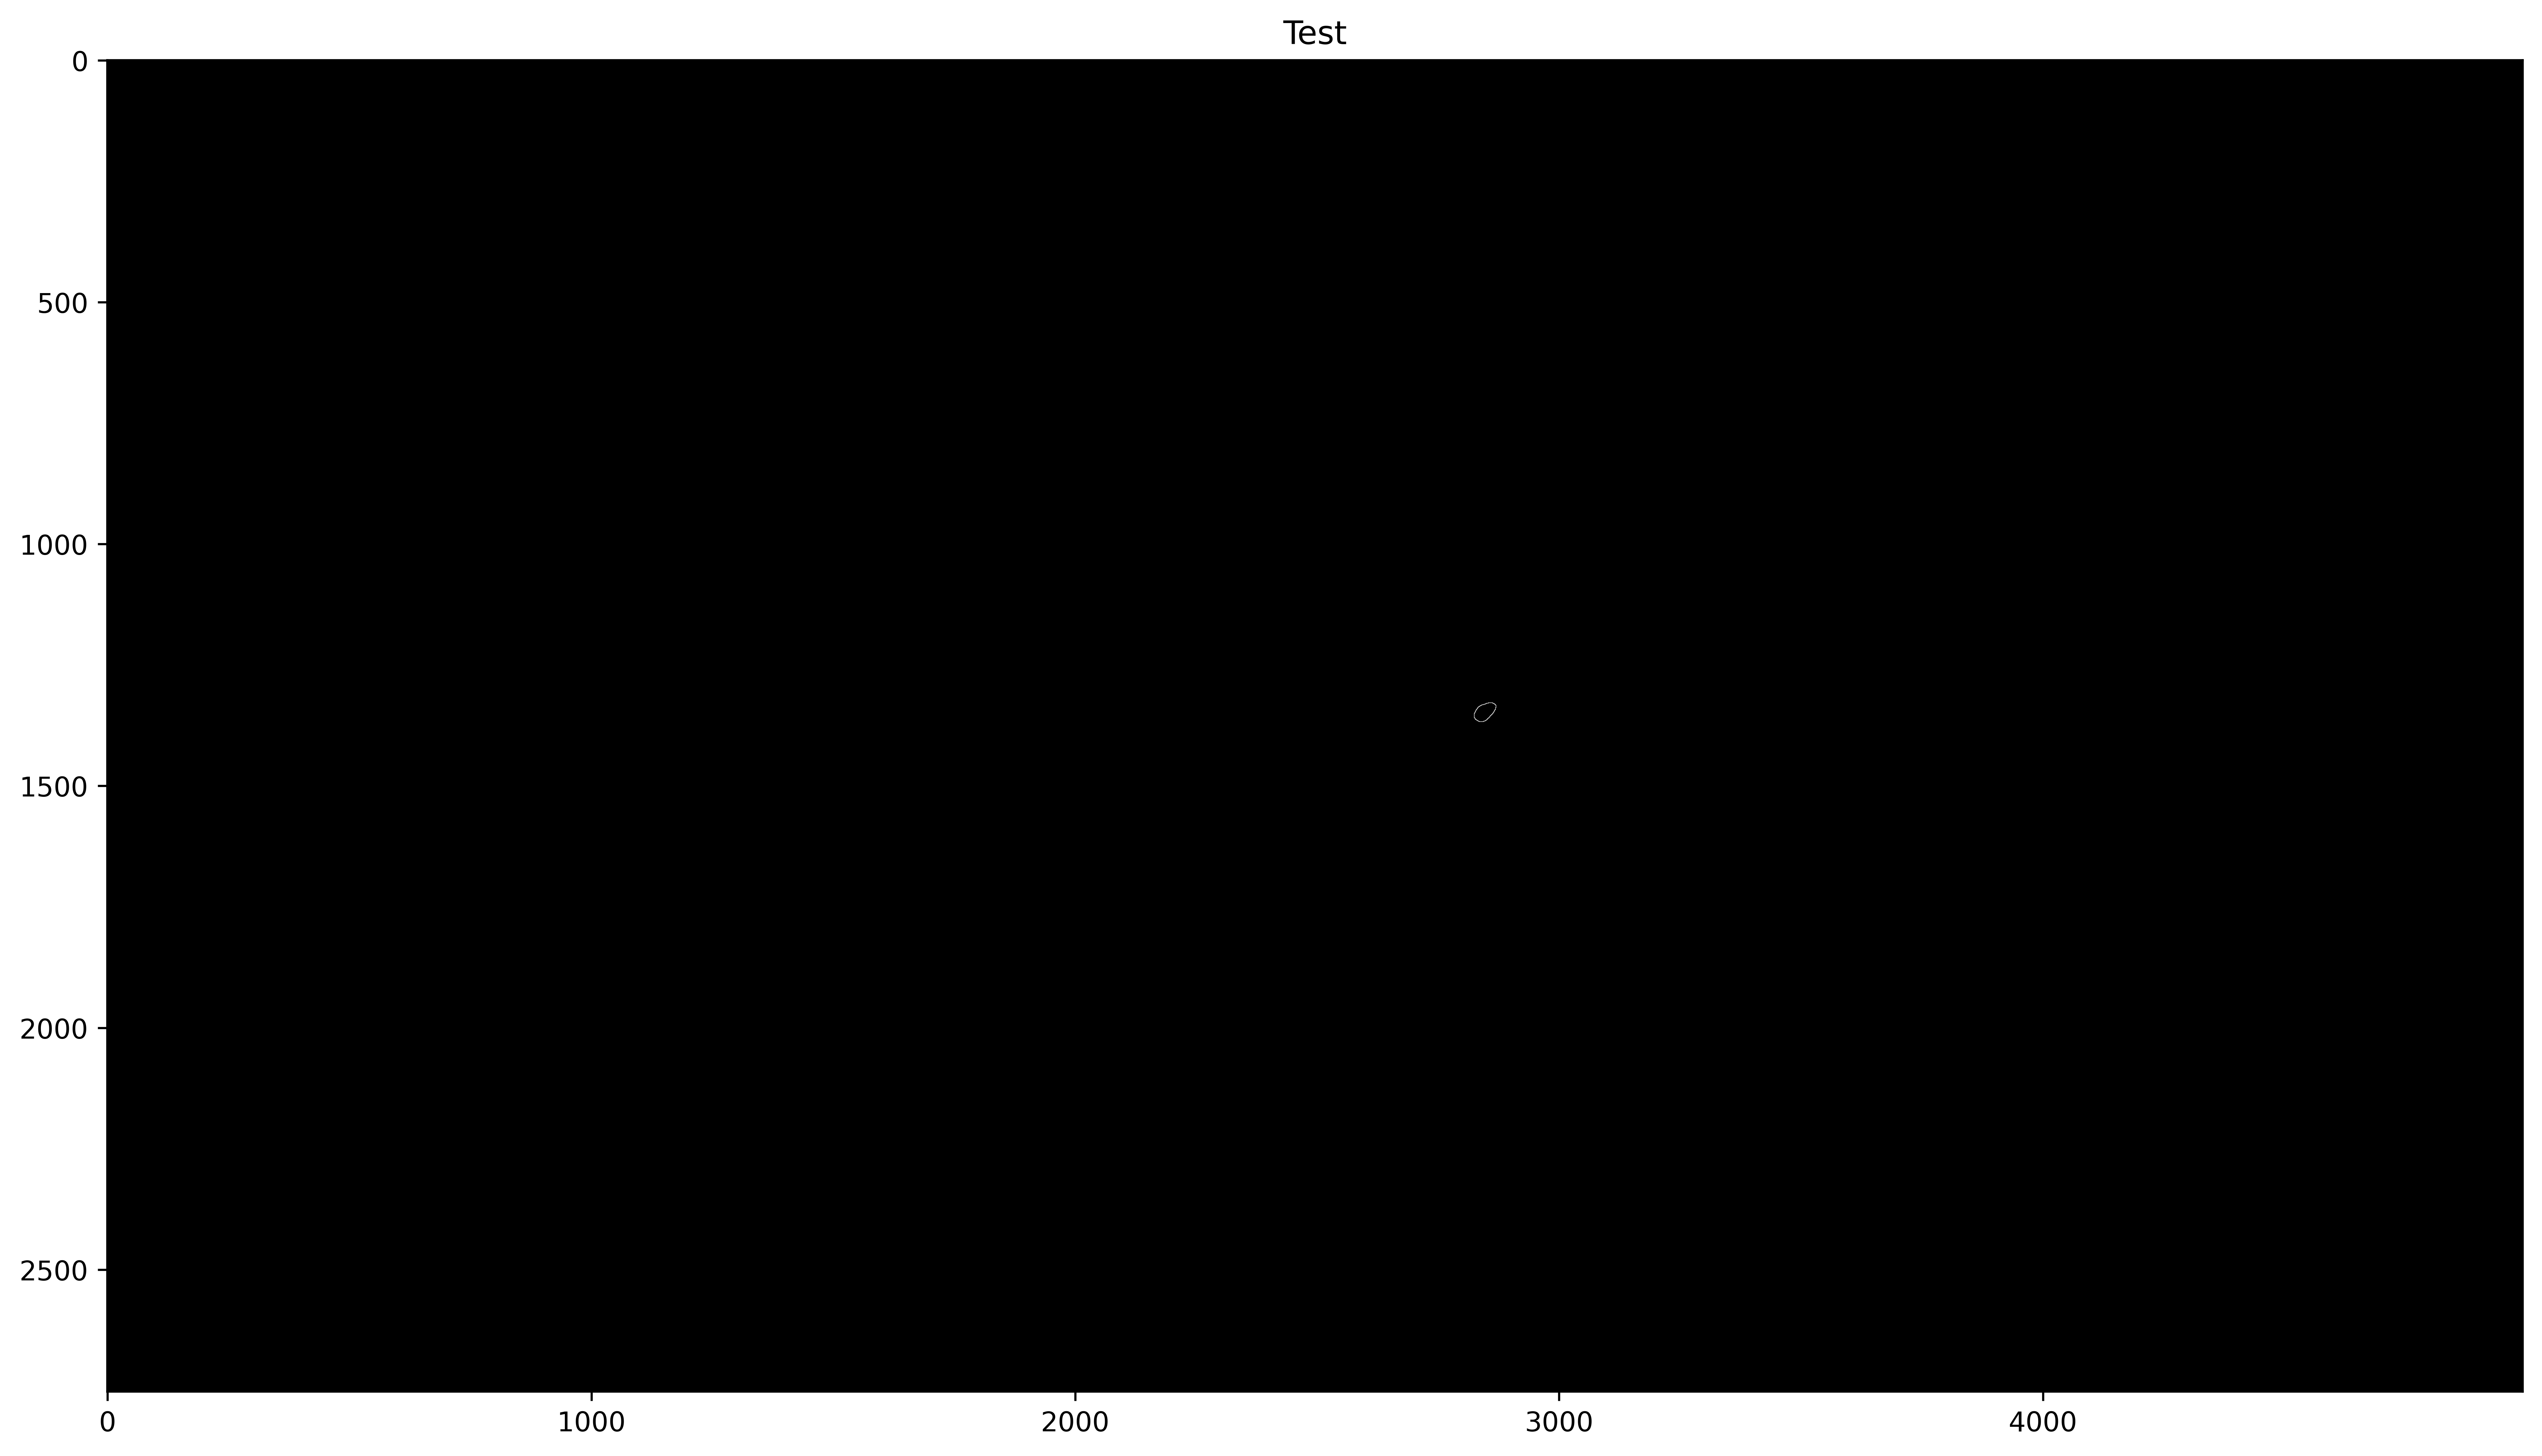

In [7]:
plt.figure(figsize=(16,10), dpi=600)
plt.imshow(membrane[680], cmap='gray')
plt.title("Test")

Text(0.5, 1.0, 'Membrane Extraction')

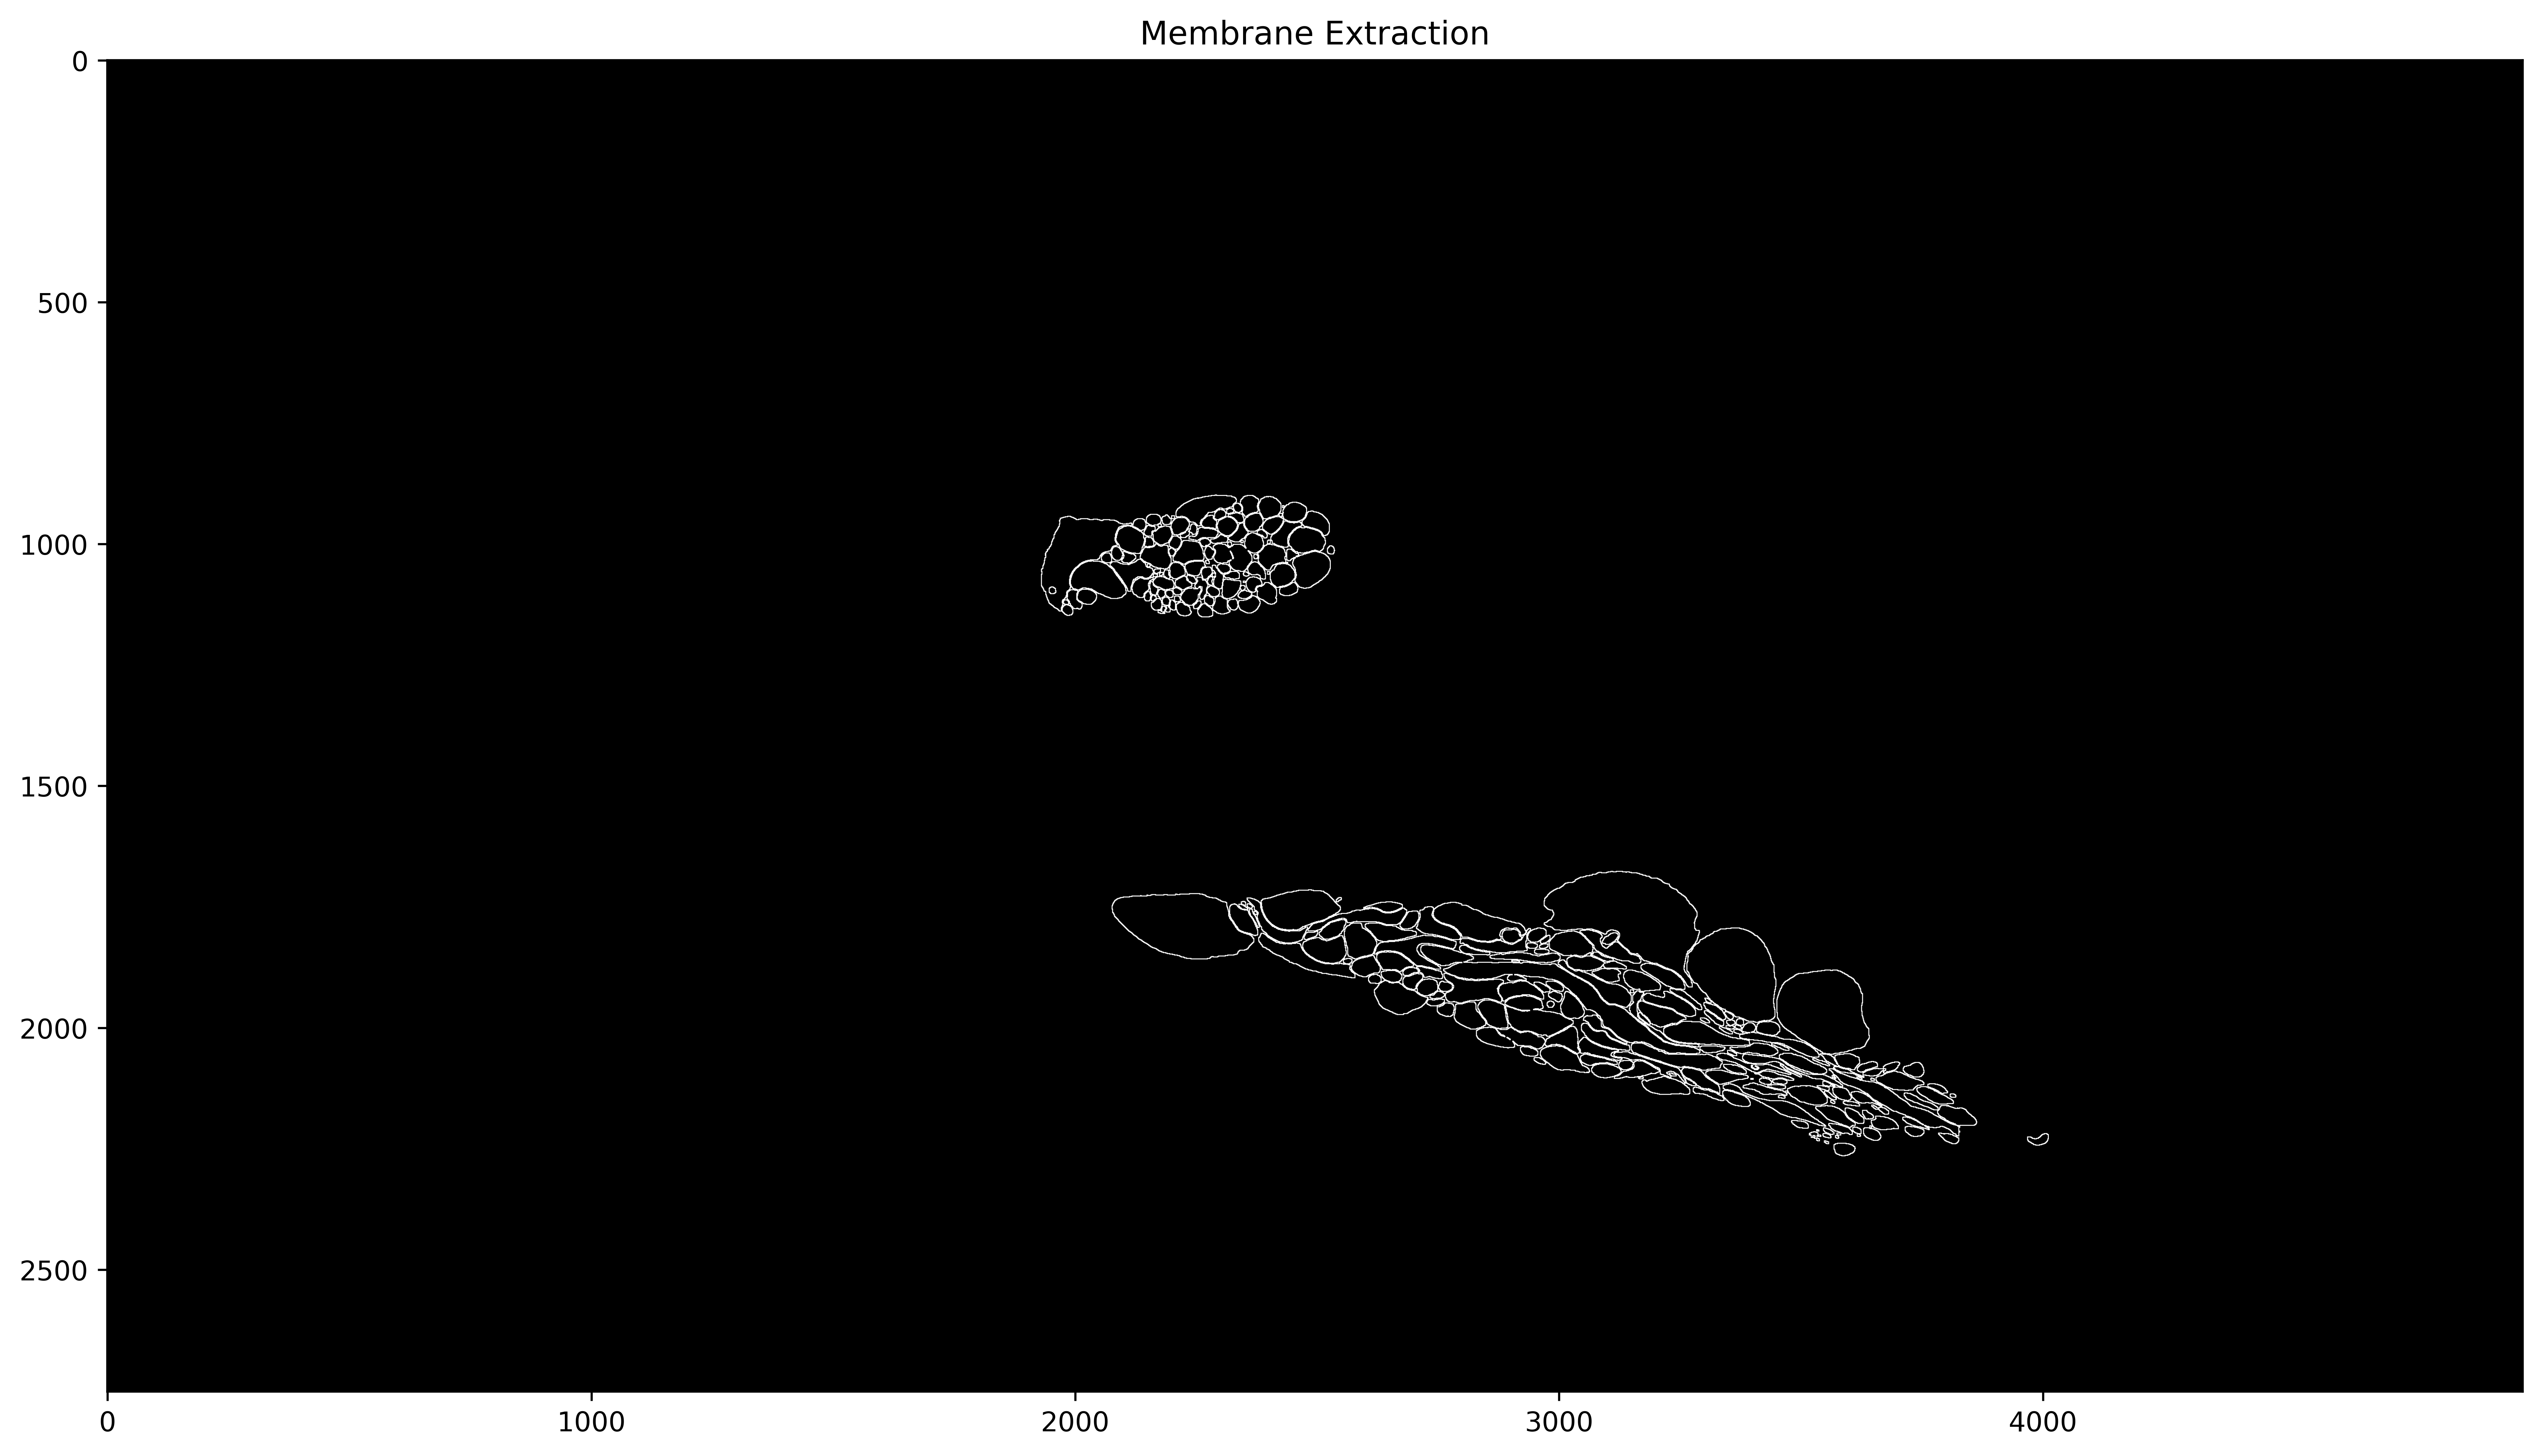

In [ ]:
#DILATION + EROSION METHOD
from scipy.ndimage import binary_erosion, grey_erosion, grey_dilation
import numpy as np

def extract_membrane_from_slice(neurons, structure_size=1):
    """
    Extract membrane using morphological gradient.
    Works by subtracting eroded from dilated version.
    """
    # For labeled data (different neuron IDs)
    dilated = grey_dilation(neurons, size=(structure_size*2+1, structure_size*2+1))
    eroded = grey_erosion(neurons, size=(structure_size*2+1, structure_size*2+1))
    
    # Membrane is where dilation and erosion differ
    membrane = (dilated != eroded).astype(np.uint8) * 255
    
    return membrane

# Usage
membrane = extract_membrane_from_slice(neurons[300,:,:], structure_size=1)
plt.figure(figsize=(16,10), dpi=600)
plt.imshow(membrane, cmap='gray')
plt.title("Membrane Extraction")

Text(0.5, 1.0, 'Gradient-Based Membrane (Thinnest)')

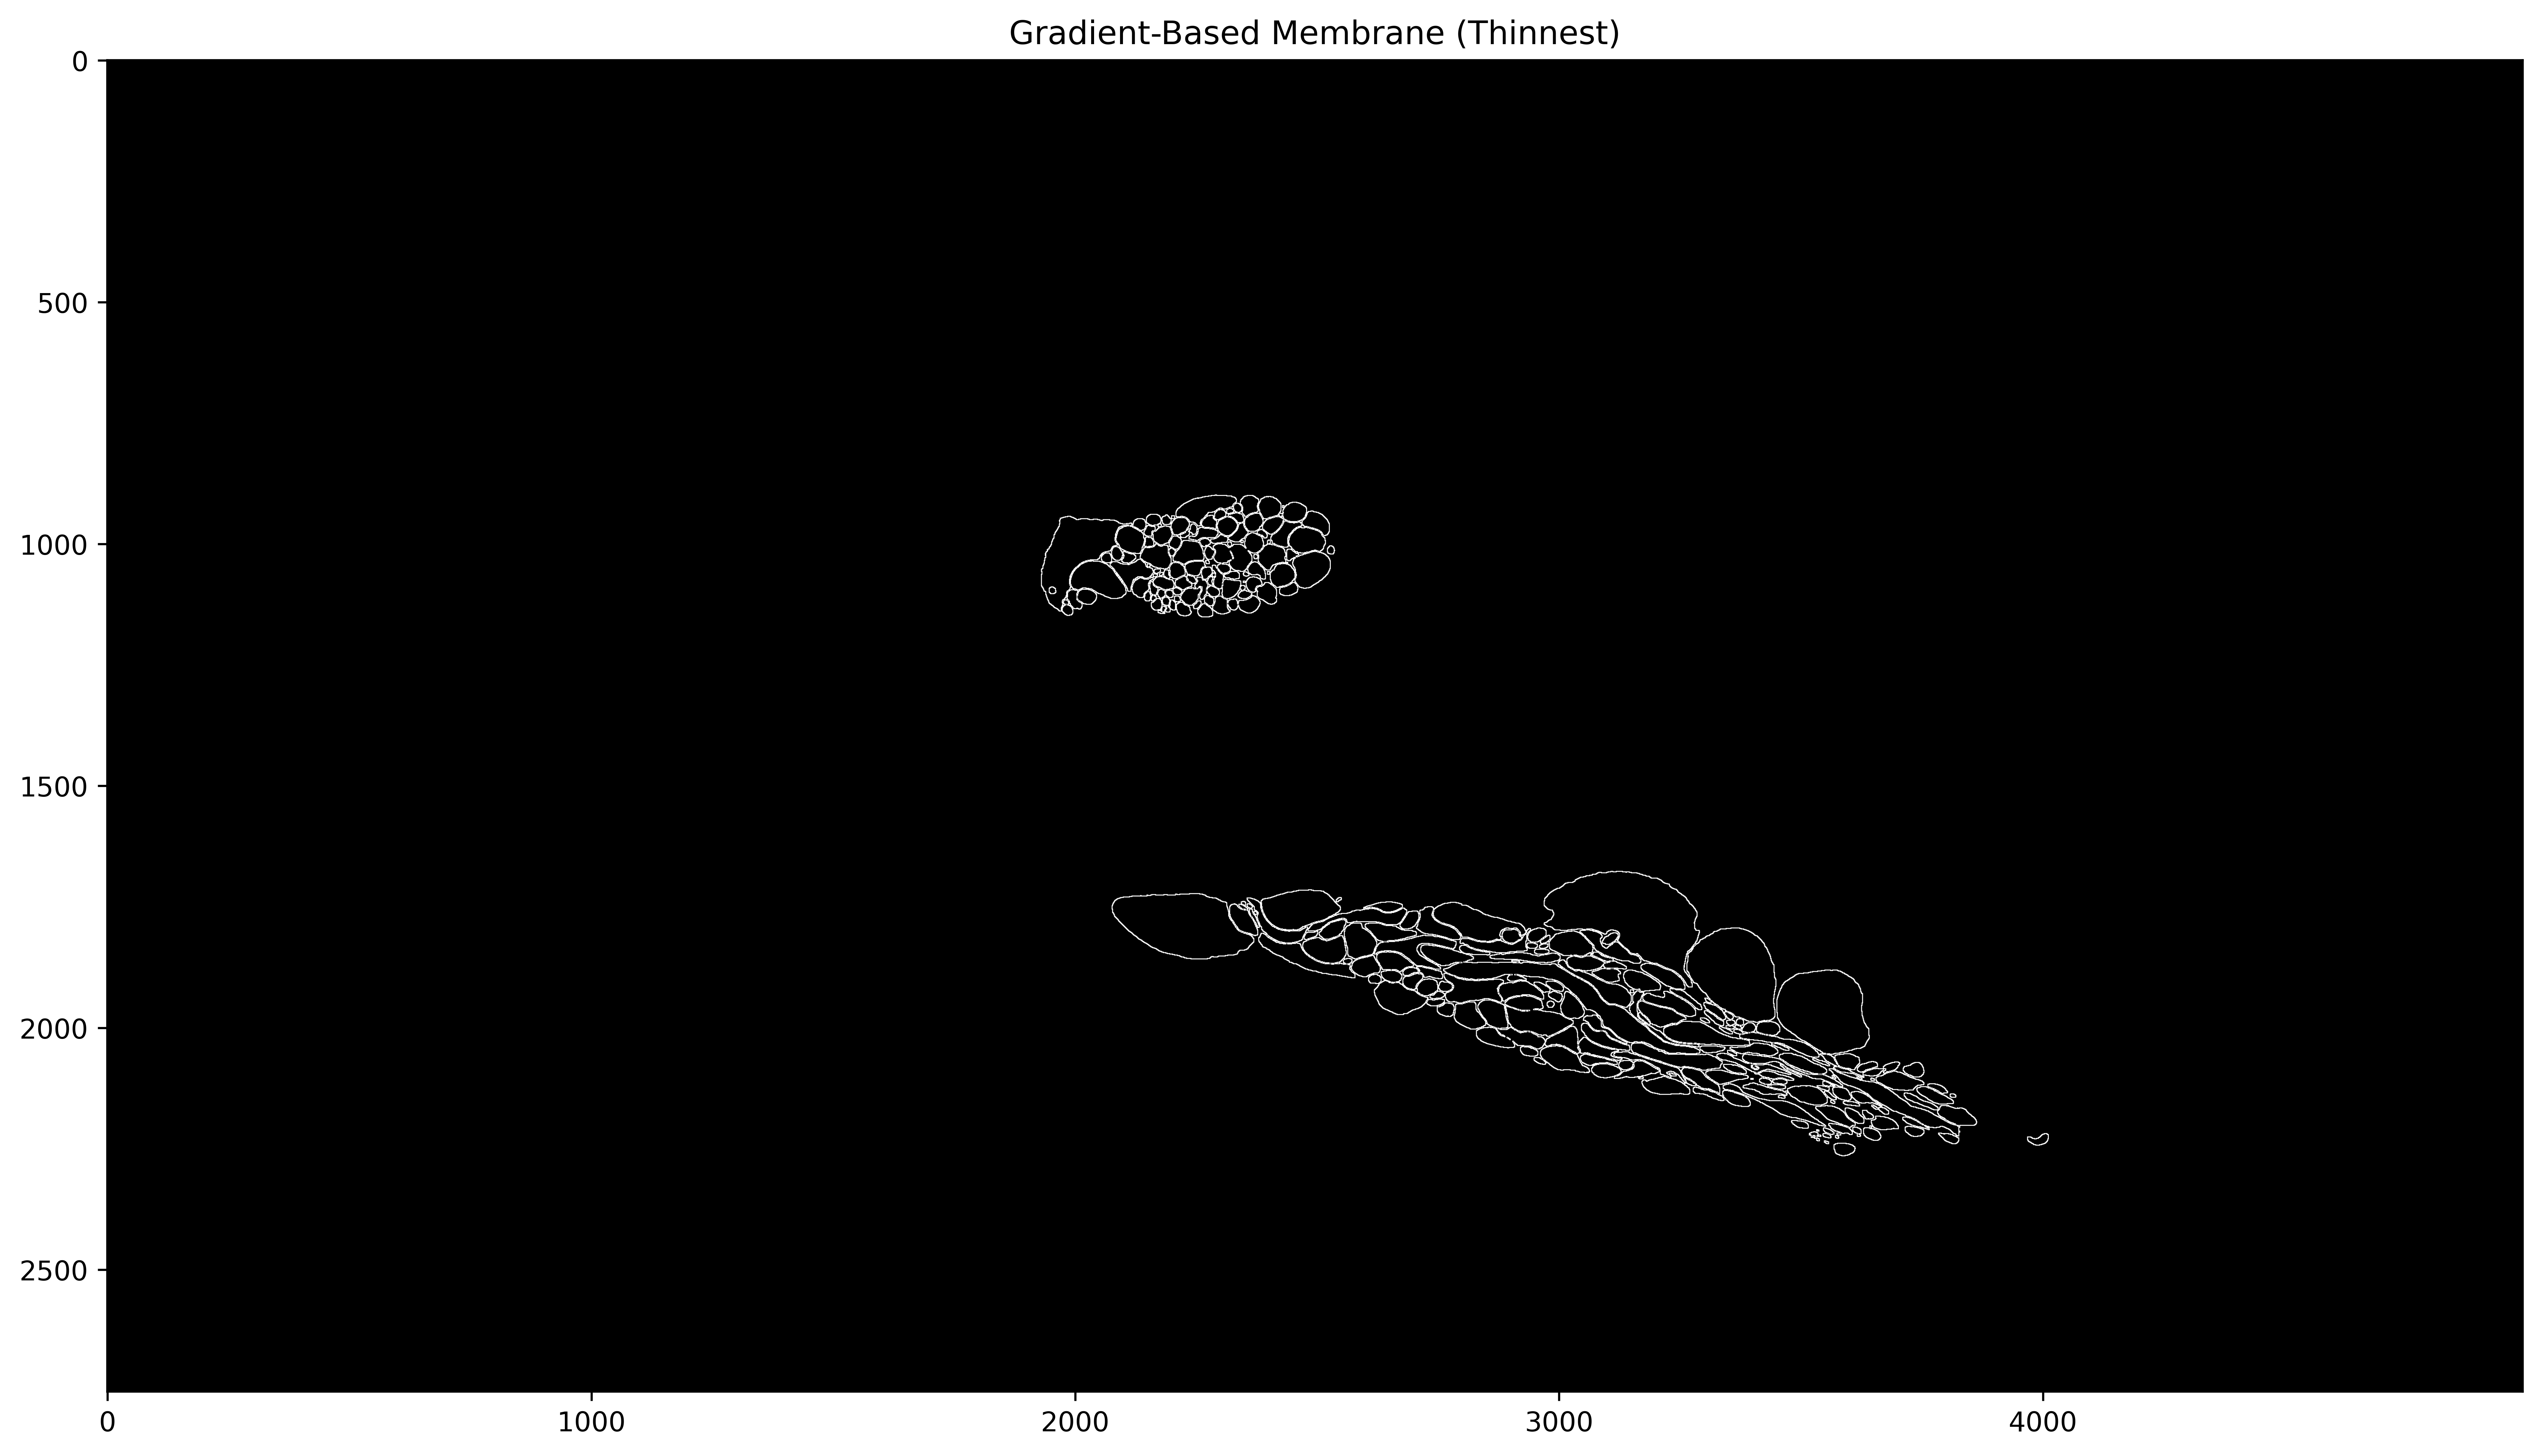

In [ ]:
#SOBEL GRADIENT METHOD
def extract_membrane_gradient(neurons):
    """Extract membrane using Sobel gradient (very thin, clean edges)"""
    from scipy.ndimage import sobel
    import numpy as np
    
    # Compute gradients
    sx = sobel(neurons.astype(float), axis=0)
    sy = sobel(neurons.astype(float), axis=1)
    
    # Gradient magnitude
    gradient = np.hypot(sx, sy)
    
    # Binary threshold (membrane where gradient > 0)
    membrane = (gradient > 0).astype(np.uint8) * 255
    
    return membrane

# Usage
membrane_gradient = extract_membrane_gradient(neurons[300,:,:])
plt.figure(figsize=(16,10), dpi=600)
plt.imshow(membrane_gradient, cmap='gray')
plt.title("Gradient-Based Membrane (Thinnest)")

In [2]:
np.unique(neurons, return_counts=True)

(array([  0, 255], dtype=uint16), array([9429683000,  186905800]))